# Experiments
This notebook can be used to perform some loopback experiments on the RFSoC.

In [1]:
# Imports and overlay loading
from scipy.signal import sawtooth
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import numpy as np

# RFSoC overlay and OLED display
from rfsoc4x2 import oled
from rfsoc_mts import mtsOverlay

oled = oled.oled_display()
oled.write("Loading overlay...")
ol = mtsOverlay('mts.bit')
oled.write("Overlay loaded")

# Convenience aliases
DAC_SR = 4.0e9  # Hz
ADC_SR = 4.0e9  # Hz
DAC_AMP = 16383.0  # 14-bit +16383/-16384 range
X_axis = (1.0 / DAC_SR) * np.arange(0, ol.dac_player.shape[0])  # seconds

print(f"DAC buffer length: {ol.dac_player.shape[0]}")
print(f"ADC buffer length: {ol.dac_capture.shape[0]}")

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/local/share/pynq-venv/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


DAC buffer length: 65536
ADC buffer length: 65536


Some helper functions we need later.

In [2]:
def calculate_fft(signal: np.ndarray, sr_hz: float):
    N = len(signal)
    if N == 0:
        return np.array([]), np.array([]), 0.0, 0.0
    T = 1.0 / sr_hz
    Y = np.fft.fft(signal)
    f = np.fft.fftfreq(N, T)
    mag = np.abs(Y)
    fsh = np.fft.fftshift(f)
    magsh = np.fft.fftshift(mag)
    idx = int(np.argmax(magsh)) if magsh.size else 0
    peak_f_mhz = (fsh[idx] / 1e6) if fsh.size else 0.0
    peak_mag = float(magsh[idx]) if magsh.size else 0.0
    return fsh, magsh, peak_f_mhz, peak_mag

def plot_fft(freq_shifted, magnitude_shifted, title="FFT"):
    plt.figure(figsize=(12, 5))
    plt.plot(freq_shifted/1e6, magnitude_shifted, linewidth=1)
    plt.title(title)
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Magnitude')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_signal(sig, time_axis, num_points=1024, title='Signal (time domain)'):
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis[:num_points], sig[:num_points])
    plt.title(title)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude [LSB]')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
def plot_signal_subplots(signals, time_axes, num_points=1024, titles=None):
    n = len(signals)
    fig, axs = plt.subplots(n, 1, figsize=(12, 3*n), sharex=True)
    if n == 1: axs = [axs]
    for i in range(n):
        axs[i].plot(time_axes[i][:num_points], signals[i][:num_points])
        axs[i].set_title(titles[i] if titles else f"Signal {i+1}")
        axs[i].set_ylabel('Amplitude [LSB]')
        axs[i].grid(True, alpha=0.3)
    axs[-1].set_xlabel('Time [s]')
    plt.tight_layout()
    plt.show()

def plot_fft_subplots(freq_lists, mag_lists, titles=None):
    n = len(freq_lists)
    fig, axs = plt.subplots(n, 1, figsize=(12, 3*n), sharex=True)
    if n == 1: axs = [axs]
    for i in range(n):
        axs[i].plot(freq_lists[i]/1e6, mag_lists[i], linewidth=1)
        axs[i].set_title(titles[i] if titles else f"FFT {i+1}")
        axs[i].set_ylabel('Magnitude')
        axs[i].grid(True, alpha=0.3)
    axs[-1].set_xlabel('Frequency [MHz]')
    plt.tight_layout()
    plt.show()


#function to create signal
def make_piecewise_ramp(
    ratios: List[int],
    freqs_hz: List[float],
    T_total_s: float,
    amp: float,
    sr_hz: float,
    max_points: int | None = None,
    *,
    width: float = 1.0,                 # 1.0 rising, 0.0 falling
    continuous_phase: bool = False,
) -> Tuple[np.ndarray, np.ndarray] | Tuple[np.ndarray, np.ndarray, Dict]:
    if len(ratios) != len(freqs_hz):
        raise ValueError("ratios and frequencies must have same length")
    if T_total_s <= 0:
        raise ValueError("T_total must be > 0")
    if not (0.0 <= width <= 1.0):
        raise ValueError("width must be in [0, 1]")

    N = max(1, int(round(T_total_s * sr_hz)))
    if max_points is not None:
        N = min(N, int(max_points))
    dt = 1.0 / sr_hz

    rsum = sum(ratios)
    seg_lengths = [int(round(N * (r / rsum))) for r in ratios]
    delta = N - sum(seg_lengths)
    i = 0
    while delta != 0 and i < len(seg_lengths) * 4:
        j = i % len(seg_lengths)
        cand = seg_lengths[j] + (1 if delta > 0 else -1)
        if cand >= 0:
            seg_lengths[j] = cand
            delta = N - sum(seg_lengths)
        i += 1

    x = np.arange(N) * dt
    y = np.zeros(N, dtype=float)
    start = 0
    phi0 = 0.0
    w2pi = 2 * np.pi
    bounds = []

    for L, f in zip(seg_lengths, freqs_hz):
        end = start + L
        if L > 0:
            t = np.arange(L) * dt
            if f == 0:
                seg = np.zeros(L)
                if continuous_phase:
                    phi0 = phi0 % (2 * np.pi)
            else:
                phase = (w2pi * f * t) + (phi0 if continuous_phase else 0.0)
                seg = amp * sawtooth(phase, width=width)
                if continuous_phase:
                    phi0 = (w2pi * f * (L * dt) + phi0) % (2 * np.pi)
            y[start:end] = seg
        bounds.append((start, end))
        start = end
    return x, y, N

# Transfer function
Here we want to test if we can improve on the signals quality by calculating the DAC's transfer function


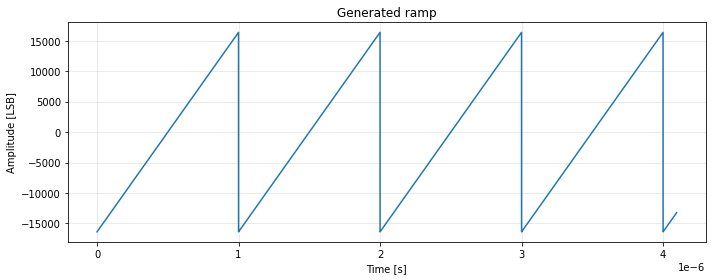

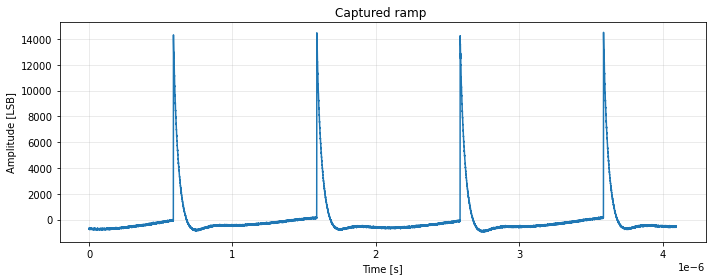

In [25]:
freqs = 1e6
signal = (DAC_AMP  ) * sawtooth(2 * np.pi * freqs * X_axis)
ol.dac_player[:] = np.int16(signal)
plot_signal(signal, X_axis, num_points=128*128, title='Generated ramp')

#perform loopback and capture signal
ol.init_tile_sync()
ol.verify_clock_tree()
ol.sync_tiles()
captured_samples = np.zeros((3,len(ol.adc_capture_chA)),dtype=np.int16)
ol.internal_capture(captured_samples)
captured =captured_samples[0][:] 

#plot analog signal
plot_signal(captured, X_axis, num_points=128*128, title='Captured ramp ')

In [56]:
freqs = 25e5
signal = (DAC_AMP/2) * sawtooth(2 * np.pi * freqs * X_axis)
ol.dac_player[:] = np.int16(signal)

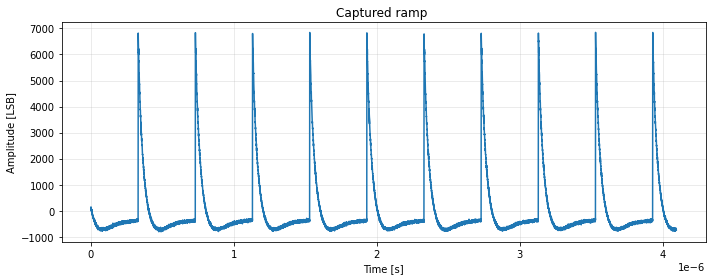

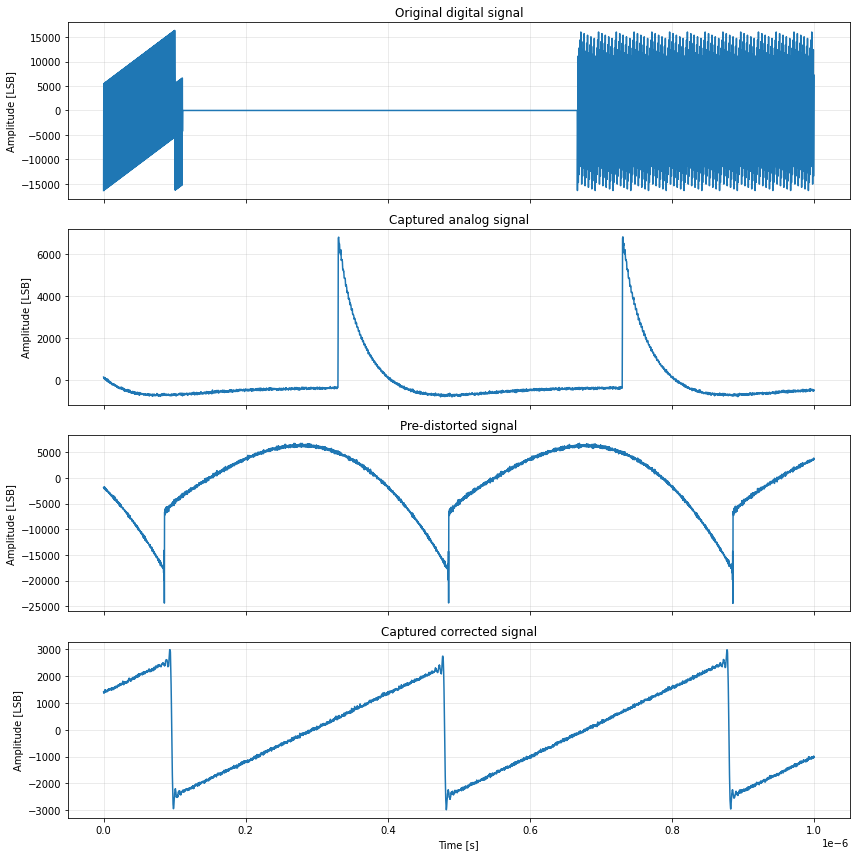

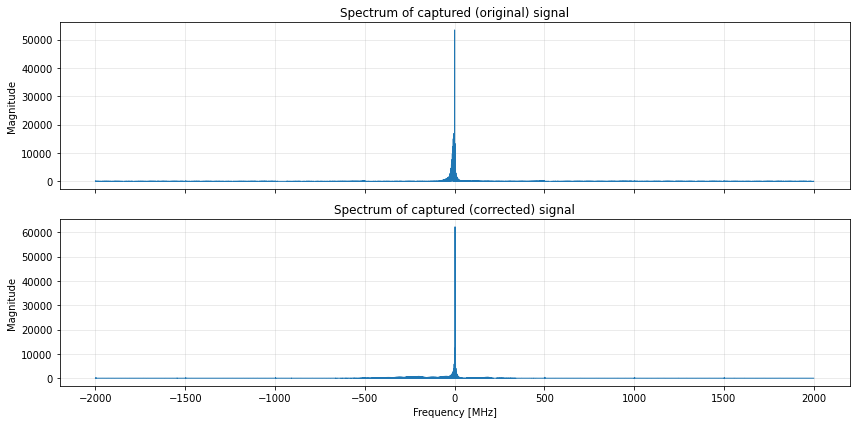

In [5]:
import time
from scipy.signal import butter, filtfilt, iirnotch

freqs = 25e5
signal = (DAC_AMP/2) * sawtooth(2 * np.pi * freqs * X_axis)
ol.dac_player[:] = np.int16(signal)

# plot_signal(signal, X_axis, num_points=2**14, title='Generated ramp')

time.sleep(1)

#perform loopback and capture signal
ol.init_tile_sync()
ol.verify_clock_tree()
ol.sync_tiles()
captured_samples = np.zeros((3,len(ol.adc_capture_chB)),dtype=np.int16)
ol.internal_capture(captured_samples)
captured =captured_samples[0][:] 

#plot analog signal
plot_signal(captured, X_axis, num_points=2**14, title='Captured ramp ')

X = np.fft.fft(signal)
Z = np.fft.fft(captured)

eps = 1e-6
H_est = Z / (X + eps)
H_inv = np.conj(H_est) / (np.abs(H_est)**2 + eps)
X_corr = X * H_inv


new_signal = np.real(np.fft.ifft(X_corr))
# new_signal = new_signal / np.max(np.abs(new_signal)) * np.max(np.abs(signal))
new_signal = new_signal / (np.max(new_signal)-np.min(new_signal)) * 2**15

# plot_signal(new_signal, X_axis, num_points=2**14, title='Changed')

b, a = butter(
    N=10, Wn=200e6, btype="lowpass", fs=ADC_SR
)
low_signal = filtfilt(b, a, new_signal)

# b, a = iirnotch(500e6, 100, ADC_SR)
# bs_signal =  filtfilt(b, a, new_signal)

# plot_signal(low_signal, X_axis, num_points=2**14, title='After lowpass filter')

time.sleep(1)


# ol.dac_player[:] = np.int16(bs_signal)
ol.dac_player[:] = np.int16(low_signal)

time.sleep(1)

#perform loopback and capture signal
ol.init_tile_sync()
captured_samples_new = np.zeros((3,len(ol.adc_capture_chB)),dtype=np.int16)
ol.verify_clock_tree()
ol.sync_tiles()
ol.internal_capture(captured_samples_new)
captured_new =captured_samples_new[0][:] 

#plot analog signal
# plot_signal(captured_new, X_axis, num_points=2**14, title='Changed captured ramp  ')

time.sleep(1)

#Apply np.exp with chosen phase scale
phase_scale = 2*np.pi / (np.max(captured)-np.min(captured))
phi = phase_scale * captured
cos_fz = np.exp(1j * phi)
fz, mz, _, _ = calculate_fft(cos_fz, ADC_SR)
# plot_fft(fz, np.log(mz), title='Spectrum captured generated')


phase_scale = 2*np.pi / (np.max(captured_new)-np.min(captured_new))
phi_new = phase_scale * captured_new
cos_fz_new = np.exp(1j * phi_new)
fz_new, mz_new, _, _ = calculate_fft(cos_fz_new, ADC_SR)
# plot_fft(fz, np.log(mz), title='Spectrum captured changed')

# Example usage:
signals = [y, captured, new_signal, captured_new]
time_axes = [X_axis]*4
titles = [
    'Original digital signal',
    'Captured analog signal',
    'Pre-distorted signal',
    'Captured corrected signal'
]
plot_signal_subplots(signals, time_axes, num_points=4000, titles=titles)

freqs = [fz, fz_new]
mags = [mz, mz_new]
fft_titles = [
    'Spectrum of captured (original) signal',
    'Spectrum of captured (corrected) signal'
]
plot_fft_subplots(freqs, mags, titles=fft_titles)

# Serrodyne signal
This section generates the exact signal with the different ramp sequences. We then calculate the resulting power after serrodyne modulation. 

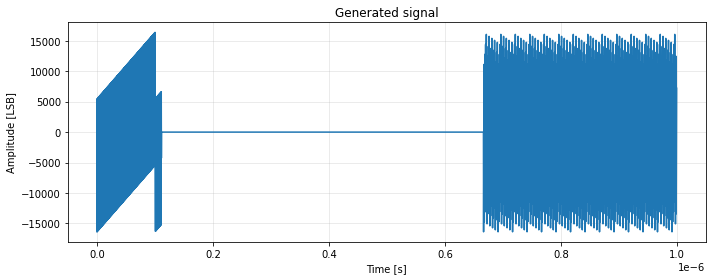

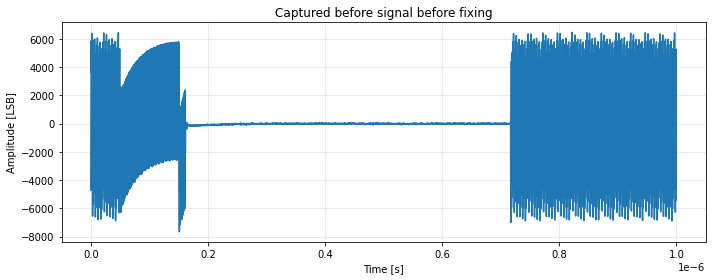

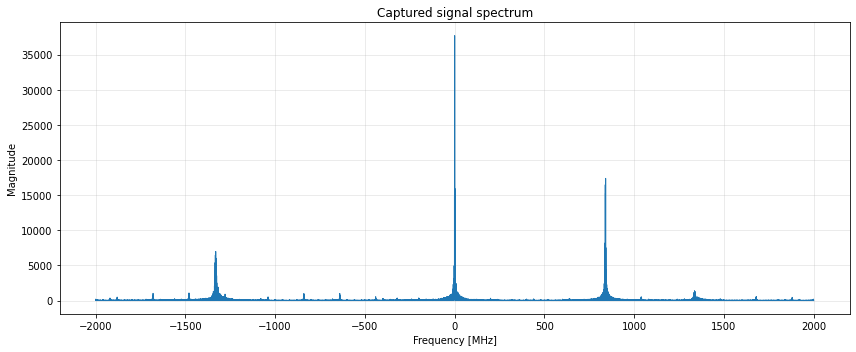

In [5]:
buf_len = int(ol.dac_player.shape[0])

#creating signal
total_time = 1e-6 
x, y, num_points = make_piecewise_ramp(
    ratios=[1, 5, 3],
    freqs_hz=[-1330e6, 0, 840e6],
    T_total_s=total_time,
    amp=DAC_AMP,
    sr_hz=DAC_SR,
    max_points=buf_len,
    width=1,
    continuous_phase=False,
)

# digital signal has num_points samples, pad to buffer length, repeat
if len(y) < buf_len:
    reps = int(np.ceil(buf_len / len(y)))
    y = np.tile(y, reps)[:buf_len]

#plot digital signal
plot_signal(y, X_axis, num_points=num_points, title='Generated signal')

#output original signal via DAC
ol.dac_player[:] = np.int16(y)


#perform loopback and capture signal
ol.init_tile_sync()
ol.verify_clock_tree()
ol.sync_tiles()
captured_samples = np.zeros((3,len(ol.adc_capture_chA)),dtype=np.int16)
ol.internal_capture(captured_samples)
captured =-captured_samples[0][:] 

#plot analog signal
plot_signal(captured, X_axis, num_points=num_points, title='Captured before signal before fixing')

# Apply np.exp with chosen phase scale
phase_scale = 2*np.pi / (np.max(captured)-np.min(captured))
phi = phase_scale * captured
cos_fz = np.exp(1j * phi)
fz, mz, _, _ = calculate_fft(cos_fz, ADC_SR)
plot_fft(fz, mz, title='Captured signal spectrum')

In [ ]:
import numpy as np
import time

ol.init_tile_sync()
ol.verify_clock_tree()
ol.sync_tiles()

captured_samples = np.zeros((3, len(ol.adc_capture_chA)), dtype=np.int16)
ol.internal_capture(captured_samples)
captured = -captured_samples[0][:]

# Plot signals
# plot_signal(y, X_axis, num_points=4000, title='Original digital signal (y)')
# plot_signal(captured, X_axis, num_points=4000, title='Captured analog signal')


# # Remove DC offset
# y_dc = y - np.mean(y)
# captured_dc = captured - np.mean(captured)

# Compute FFTs
X = np.fft.fft(y)
Z = np.fft.fft(captured)

# Estimate frequency response: H(f) = Z / X
# eps = 1e-6
H_est = Z / (X)

# Regularized inverse filter
# H_inv = np.conj(H_est) / (np.abs(H_est)**2)
H_inv = 1 / (H_est + 1e-8)

# Apply inverse in frequency domain
X_corr = X * H_inv

# Back to time domain (real signal)
new_signal = np.real(np.fft.ifft(X_corr))

# Normalize amplitude to original signal range
new_signal = new_signal / np.max(np.abs(new_signal)) * np.max(np.abs(y))

# Plot pre-distorted signal
# plot_signal(new_signal, X_axis, num_points=4000, title='Pre-distorted signal (Changed)')

time.sleep(1)
ol.dac_player[:] = np.int16(new_signal)

time.sleep(1)
ol.init_tile_sync()
ol.verify_clock_tree()

captured_samples_new = np.zeros((3, len(ol.adc_capture_chA)), dtype=np.int16)
ol.internal_capture(captured_samples_new)
captured_new = -captured_samples_new[0][:]

# Plot captured corrected analog signal
# plot_signal(captured_new, X_axis, num_points=4000, title='Captured corrected signal')

# Convert captured signals to phase domain for FFT visualization
phase_scale = 2 * np.pi / (np.max(captured) - np.min(captured))
phi = phase_scale * captured
cos_fz = np.exp(1j * phi)
fz, mz, _, _ = calculate_fft(cos_fz, ADC_SR)
# plot_fft(fz, mz, title='Spectrum of captured (original) signal')

phase_scale_new = 2 * np.pi / (np.max(captured_new) - np.min(captured_new))
phi_new = phase_scale_new * captured_new
cos_fz_new = np.exp(1j * phi_new)
fz_new, mz_new, _, _ = calculate_fft(cos_fz_new, ADC_SR)
# plot_fft(fz_new, mz_new, title='Spectrum of captured (corrected) signal')

time.sleep(1)

signals = [y, captured, new_signal, captured_new]
time_axes = [X_axis]*4
titles = [
    'Original digital signal',
    'Captured analog signal',
    'Pre-distorted signal',
    'Captured corrected signal'
]
plot_signal_subplots(signals, time_axes, num_points=4000, titles=titles)

freqs = [fz, fz_new]
mags = [mz, mz_new]
fft_titles = [
    'Spectrum of captured (original) signal',
    'Spectrum of captured (corrected) signal'
]
plot_fft_subplots(freqs, mags, titles=fft_titles)


# Checking magnitude ratios

Measured fractions:
  DC      :  0.583
  840 MHz :  0.321
  1330 MHz:  0.095
Expected fractions:
  DC      :  0.556
  840 MHz :  0.333
  1330 MHz:  0.111


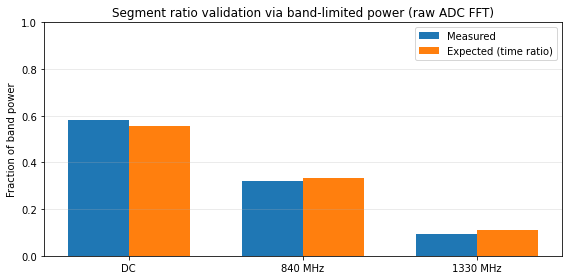

In [62]:
# Convert to power spectrum
p_spec = (np.abs(mz))**2

# Helper to integrate power in a frequency window [f0-df, f0+df]
def band_power(f_axis, p_axis, f0, df):
    mask = (f_axis >= (f0 - df)) & (f_axis <= (f0 + df))
    if not np.any(mask):
        return 0.0
    return float(np.sum(p_axis[mask]))

# Expected component fundamentals (Hz) and label
components = [(0.0, "DC"), (840e6, "840 MHz"), (-1330e6, "1330 MHz")]

# Because sawtooth has rich harmonics, include a few harmonic bands for each non-DC
max_harm = 5  # odd/even both possible for sawtooth; adjust as needed
df = 8e6      # +/-8 MHz window; tune based on leakage and resolution

power_per_component = []
for f0, label in components:
    if f0 == 0.0:
        # DC: integrate around 0 Hz
        p = band_power(fz, p_spec, 0.0, df)
    else:
        p = 0.0
        # integrate fundamentals + harmonics within Nyquist
        for k in range(1, max_harm+1):
            fk = k * f0
            # wrap/aliasing: only integrate if within measured freq span
            if fk <= np.max(np.abs(fz)):
                p += band_power(fz, p_spec, fk, df)
    power_per_component.append((label, p))

total_p = sum(p for _, p in power_per_component) or 1.0
fractions = [(label, p/total_p) for label, p in power_per_component]

# Expected time fractions from ratios [5,3,1]
ratios = np.array([5,3,1], dtype=float)
expected = ratios / ratios.sum()
expected_labels = ["DC", "840 MHz", "1330 MHz"]

# Print numeric comparison
print("Measured fractions:")
for label, frac in fractions:
    print(f"  {label:8s}: {frac: .3f}")
print("Expected fractions:")
for label, frac in zip(expected_labels, expected):
    print(f"  {label:8s}: {frac: .3f}")

# Bar plot comparison
labels = expected_labels
measured_vec = [dict(fractions)[lab] for lab in labels]
x = np.arange(len(labels))
w = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - w/2, measured_vec, width=w, label='Measured')
plt.bar(x + w/2, expected,     width=w, label='Expected (time ratio)')
plt.xticks(x, labels)
plt.ylabel('Fraction of band power')
plt.title('Segment ratio validation via band-limited power (raw ADC FFT)')
plt.ylim(0, 1)
plt.grid(True, axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
